# Statistical Power - Lab

## Introduction


In this lesson, you'll practice doing a power-analysis during experimental design. As you've seen, power analysis allows you to determine the sample size required to detect an effect of a given size with a given degree of confidence. In other words, it allows you to determine the probability of detecting an effect of a given size with a given level of confidence, under-sample size constraints.

The following four factors have an intimate relationship:

* Sample size
* Effect size
* Significance level = P (Type I error) = probability of finding an effect that is not there
* **Power = 1 - P (Type II error)** = probability of finding an effect that is there

Given any three of these, we can easily determine the fourth.

## Objectives

In this lab you will: 

- Describe the impact of sample size and effect size on power 
- Perform power calculation using SciPy and Python 
- Demonstrate the combined effect of sample size and effect size on statistical power using simulations

## Let's get started!
  
To start, let's import the necessary libraries required for this simulation: 

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Scenario

A researcher wants to study how daily protein supplementation in the elderly population will affect baseline liver fat. The study budget will allow enrollment of 24 patients. Half will be randomized to a placebo group and half to the protein supplement treatment group and the trial will be carried out over one month. It is desired to see whether the mean change in percentage of liver fat from baseline to the end of the study differs between the two groups in the study. 

With this, the researcher writes the null hypothesis: 

    There is no difference between experimental and control group mean change in percentage of liver fat 
    
$$\mu_{1} = \mu_{2}$$
  
And the alternative Hypothesis:

    There is a difference between experimental and control group mean change in percentage of liver fat 

$$\mu_{1} \neq \mu_{2}$$
    
  

The researcher needs to know what power  will be obtained under the sample size restrictions to identify a change in mean percent liver fat of 0.17. Based on past results, a common standard deviation of 0.21 will be used for each treatment group in the power analysis. 

To determine the practicality of this experimental design, you'll run a power analysis simulation: 

In [2]:
# Number of patients in each group
sample_size = 12

# Control group
control_mean = 0
control_sd = .21

# Experimental group
experimental_mean = .17
experimental_sd = .21

# Set the number of simulations for our test = 1000
n_sim = 1000

You can now start running simulations to run an independent t-test with above data and store the calculated p-value in our `p` array. Perform following tasks: 

* Initialize a numpy array and fill it with `NaN` values for storing the results (p_value) of the independent t-test  
* For a defined number of simulations (i.e., 1000), do the following:

    * Generate a random normal variable with control mean and sd
    * Generate a random normal variable with experimental mean and sd
    * Run and independent t-test using control and experimental data
    * Store the p value for each test

* Calculate the total number and overall proportion of simulations where the null hypothesis is rejected


In [3]:
# For reproducibility 
np.random.seed(10)

# Initialize array to store results
p = (np.empty(n_sim))
p.fill(np.nan)

for s in range(n_sim):

    control = np.random.normal(loc= control_mean, scale=control_sd, size=sample_size)
    
    experimental = np.random.normal(loc= experimental_mean, scale=experimental_sd, size=sample_size)
    
    t_test = stats.ttest_ind(control, experimental)
    
    p[s] = t_test[1]

# number of null hypothesis rejections
num_null_rejects = np.sum(p < 0.05)
power = num_null_rejects/float(n_sim)

power

0.495

These results indicate that using 12 participants in each group and with given statistics, the statistical power of the experiment is 49%. This can be interpreted as follows:

> **If a large effect (0.17 or greater) is truly present between control and experimental groups, then the null hypothesis (i.e. no difference with alpha 0.05) would be rejected 49% of the time. **

## Sample size requirements for a given effect size

Often in behavioral research 0.8 is accepted as a sufficient level of power.  

Clearly, this is not the case for the experiment as currently designed. Determine the required sample size in order to identify a difference of 0.17 or greater between the group means with an 80% power.

In [4]:
# Required power
target = 0.8

In [5]:
from statsmodels.stats.power import TTestIndPower
power = TTestIndPower()

In [6]:
# Determine the sample size
power.solve_power(effect_size=0.17/0.21, alpha=0.05, power=0.8)

24.951708908275144

In [7]:
# Minimum sample size to start the simulations 
sample_size = 12
null_rejected = 0
n_sim = 10000

As above, perform the following

* Initialize an empty array for storing results
* initialize a list for storing sample size x power summary
* While current power is less than the target power
    * Generate distributions for control and experimental groups using given statistics (as before)
    * Run a t-test and store results
    * Calculate current power 
    * Output current sample size and power calculated for inspection
    * Store results: Sample size, power
    * increase the sample size by 1 and repeat

In [11]:
np.random.seed(10)

p = (np.empty(n_sim))
p.fill(np.nan)

# Keep iterating until desired power is obtained

power_sample = []
while null_rejected < target:

    data = np.empty([n_sim, sample_size, 2])
    data.fill(np.nan)
    
    # For control group 
    # Here we specify size=[n_sim, sample_size] which creates an array of n_sim number of arrays,
    # each containing sample_size number of elements. 
    # This is equivalent to manually looping n_sim times like we did above but is much faster.
    data[:,:,0] = np.random.normal(loc=control_mean, scale=control_sd, size=[n_sim, sample_size])
    
    # For experimental group
    data[:,:,1] = np.random.normal(loc=experimental_mean, scale=experimental_sd, size=[n_sim, sample_size])            
    
    result = stats.ttest_ind(data[:, :, 0],data[:, :, 1],axis=1)
                                
    p_vals = result[1]

    # Since you know that all simulations are from a different distribution \
    # all those that rejected the null-hypothesis are valid
    null_rejected = np.sum(p_vals < 0.05) / n_sim

    print('Number of Samples:', sample_size,', Calculated Power =', null_rejected)
    power_sample.append([sample_size, null_rejected])

    # increase the number of samples by one for the next iteration of the loop
    sample_size += 1
    

You can also plot the calculated power against sample size to visually inspect the effect of increasing sample size. 

KeyError: 0

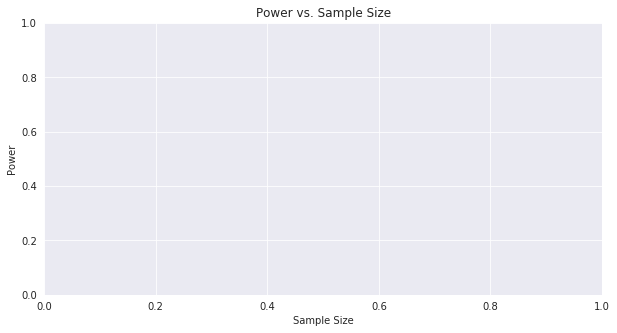

In [12]:

plt.figure(figsize=(10,5))
plt.title('Power vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Power')

ans = power_sample
df = pd.DataFrame(ans, index=None)
plt.plot(df[0], df[1])

plt.show()

This output indicates that in order to get the required power (80%) to detect a difference of 0.17, you would need a considerably higher number of patients. 

## BONUS: Investigating the relationship between Power, Sample Size, and Effect Size

You've seen how to calculate power given alpha, sample size, and effect size. To further investigate this relationship, it is interesting to plot the relationship between power and sample size for various effect sizes. 

To do this, run multiple simulations for varying parameters. Then store the parameters and plot the resulting dataset. Specifically:

1. Use a value of $\alpha$ = 0.05 for all of your simulations
2. Use the following effect sizes: [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
3. Use the sample sizes from 10 to 500
4. For each effect size sample size combination, calculate the accompanying power
5. Plot a line graph of the power vs sample size relationship. You should have 7 plots; one for each of the effect sizes listed above. All 7 plots can be on the same graph but should be labeled appropriately. Plot the power on the y-axis and sample size on the x-axis.

## Summary

In this lesson, you gained further practice with "statistical power" and how it can be used to analyze experimental design. You ran a simulation to determine the sample size that would provide a given value of power (for a given alpha and effect size). Running simulations like this, as well as further investigations regarding required sample sizes for higher power thresholds or smaller effect sizes is critical in designing meaningful experiments where one can be confident in the subsequent conclusions drawn.